In [ ]:
import os
import wget
import mutagen
import mutagen.wave
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt

In [2]:
def create_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

workspace = "./workspace"
dataset_path = os.path.join(workspace, "UrbanSound8k")
UrbanSound8k_raw_path = os.path.join(dataset_path, 'raw')

create_path(workspace)
create_path(dataset_path)
create_path(UrbanSound8k_raw_path)

if not os.path.exists(os.path.join(dataset_path, 'UrbanSound8K.tar.gz')):
    print("-------------Downloading Dataset-------------")
    wget.download('https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz', out=dataset_path)
    !tar -xzf ./workspace/UrbanSound8k/UrbanSound8K.tar.gz --directory ./workspace/UrbanSound8k/raw
    print("-------------Success-------------")

In [3]:
!cat ./workspace/UrbanSound8k/raw/UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [4]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        fold = row['fold']
        file_name = row['slice_file_name']
        filepaths.append(os.path.join(UrbanSound8k_raw_path, 'UrbanSound8K/audio', f'fold{fold}', file_name))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [5]:
dataset_df = create_dataset_df(os.path.join(UrbanSound8k_raw_path, 'UrbanSound8K/metadata/UrbanSound8K.csv'))
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,./workspace/UrbanSound8k/raw/UrbanSound8K/audi...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,./workspace/UrbanSound8k/raw/UrbanSound8K/audi...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,./workspace/UrbanSound8k/raw/UrbanSound8K/audi...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,./workspace/UrbanSound8k/raw/UrbanSound8K/audi...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,./workspace/UrbanSound8k/raw/UrbanSound8K/audi...


In [6]:
dataset_df.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

In [7]:
def get_audio_meta(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata 

def extract_meta(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    for filepath in dataset_df['filepath']:
        metadata = get_audio_meta(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]
    return dataset_df

In [8]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'classID', 'fsID', 'start', 'end'])
statistics_df = extract_meta(dataset_df)
statistics_df.describe()

,salience,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,3.603644,1.800775e+06,1.915369,48456.979272,18.780119
std,0.476043,0.980913,9.765852e+05,0.278348,15300.080707,4.227168
min,1.000000,0.000816,4.409600e+04,1.000000,8000.000000,4.000000
25%,1.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
50%,1.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
75%,2.000000,4.000000,2.116800e+06,2.000000,48000.000000,24.000000
max,2.000000,4.000000,1.228800e+07,2.000000,192000.000000,32.000000


In [9]:
statistics_df['sample_rate'].value_counts()

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sample_rate, dtype: int64

In [10]:
statistics_df['bits_per_sample'].value_counts()

16    5758
24    2753
32     169
8       43
4        9
Name: bits_per_sample, dtype: int64

In [11]:
statistics_df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                  length            ... sample_rate           bits_per_sample  \
                   count      mean  ...         75%       max           count   
class                               ...                                         
air_conditioner   1000.0  3.994928  ...     48000.0   48000.0          1000.0   
car_horn           429.0  2.456123  ...     48000.0   96000.0           429.0   
children_playing  1000.0  3.933895  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  3.148281  ...     48000.0   96000.0          1000.0   
drilling          1000.0  3.542295  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  3.935952  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  1.647699  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  3.609071  ...     48000.0   96000.0          1000.0   
siren              929.0  3.910314  ...     48000.0   48000.0           929.0   
street_music      1000.0  4.000000  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 48 columns]

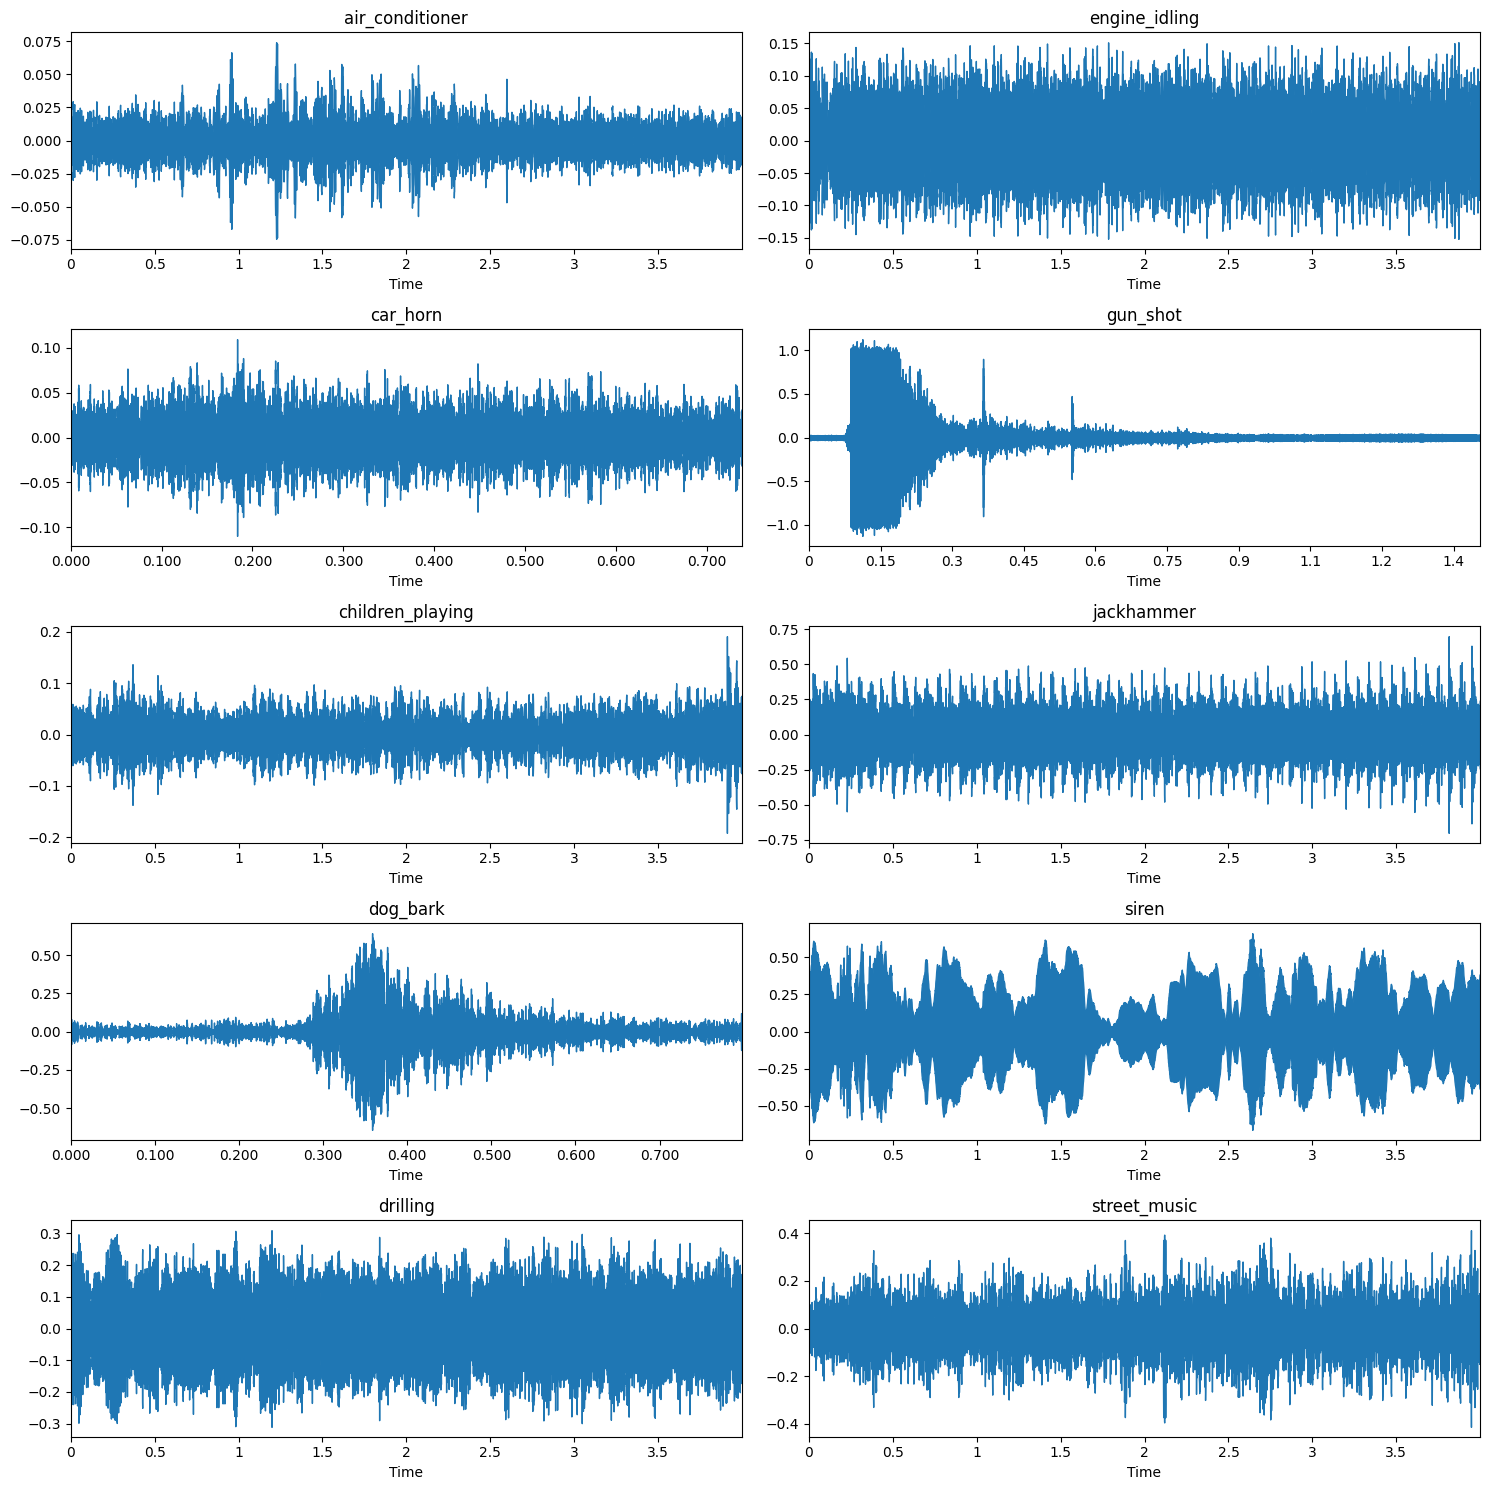

In [12]:
random_sample = dataset_df.groupby('class').sample(1)
audio_sample, label = random_sample['filepath'].tolist(), random_sample['class'].tolist()

fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_sample[index])
        librosa.display.waveplot(audio_file, sample_rate, ax=axs[row][col])
        axs[row][col].set_title(f'{label[index]}')
        index += 1
fig.tight_layout()

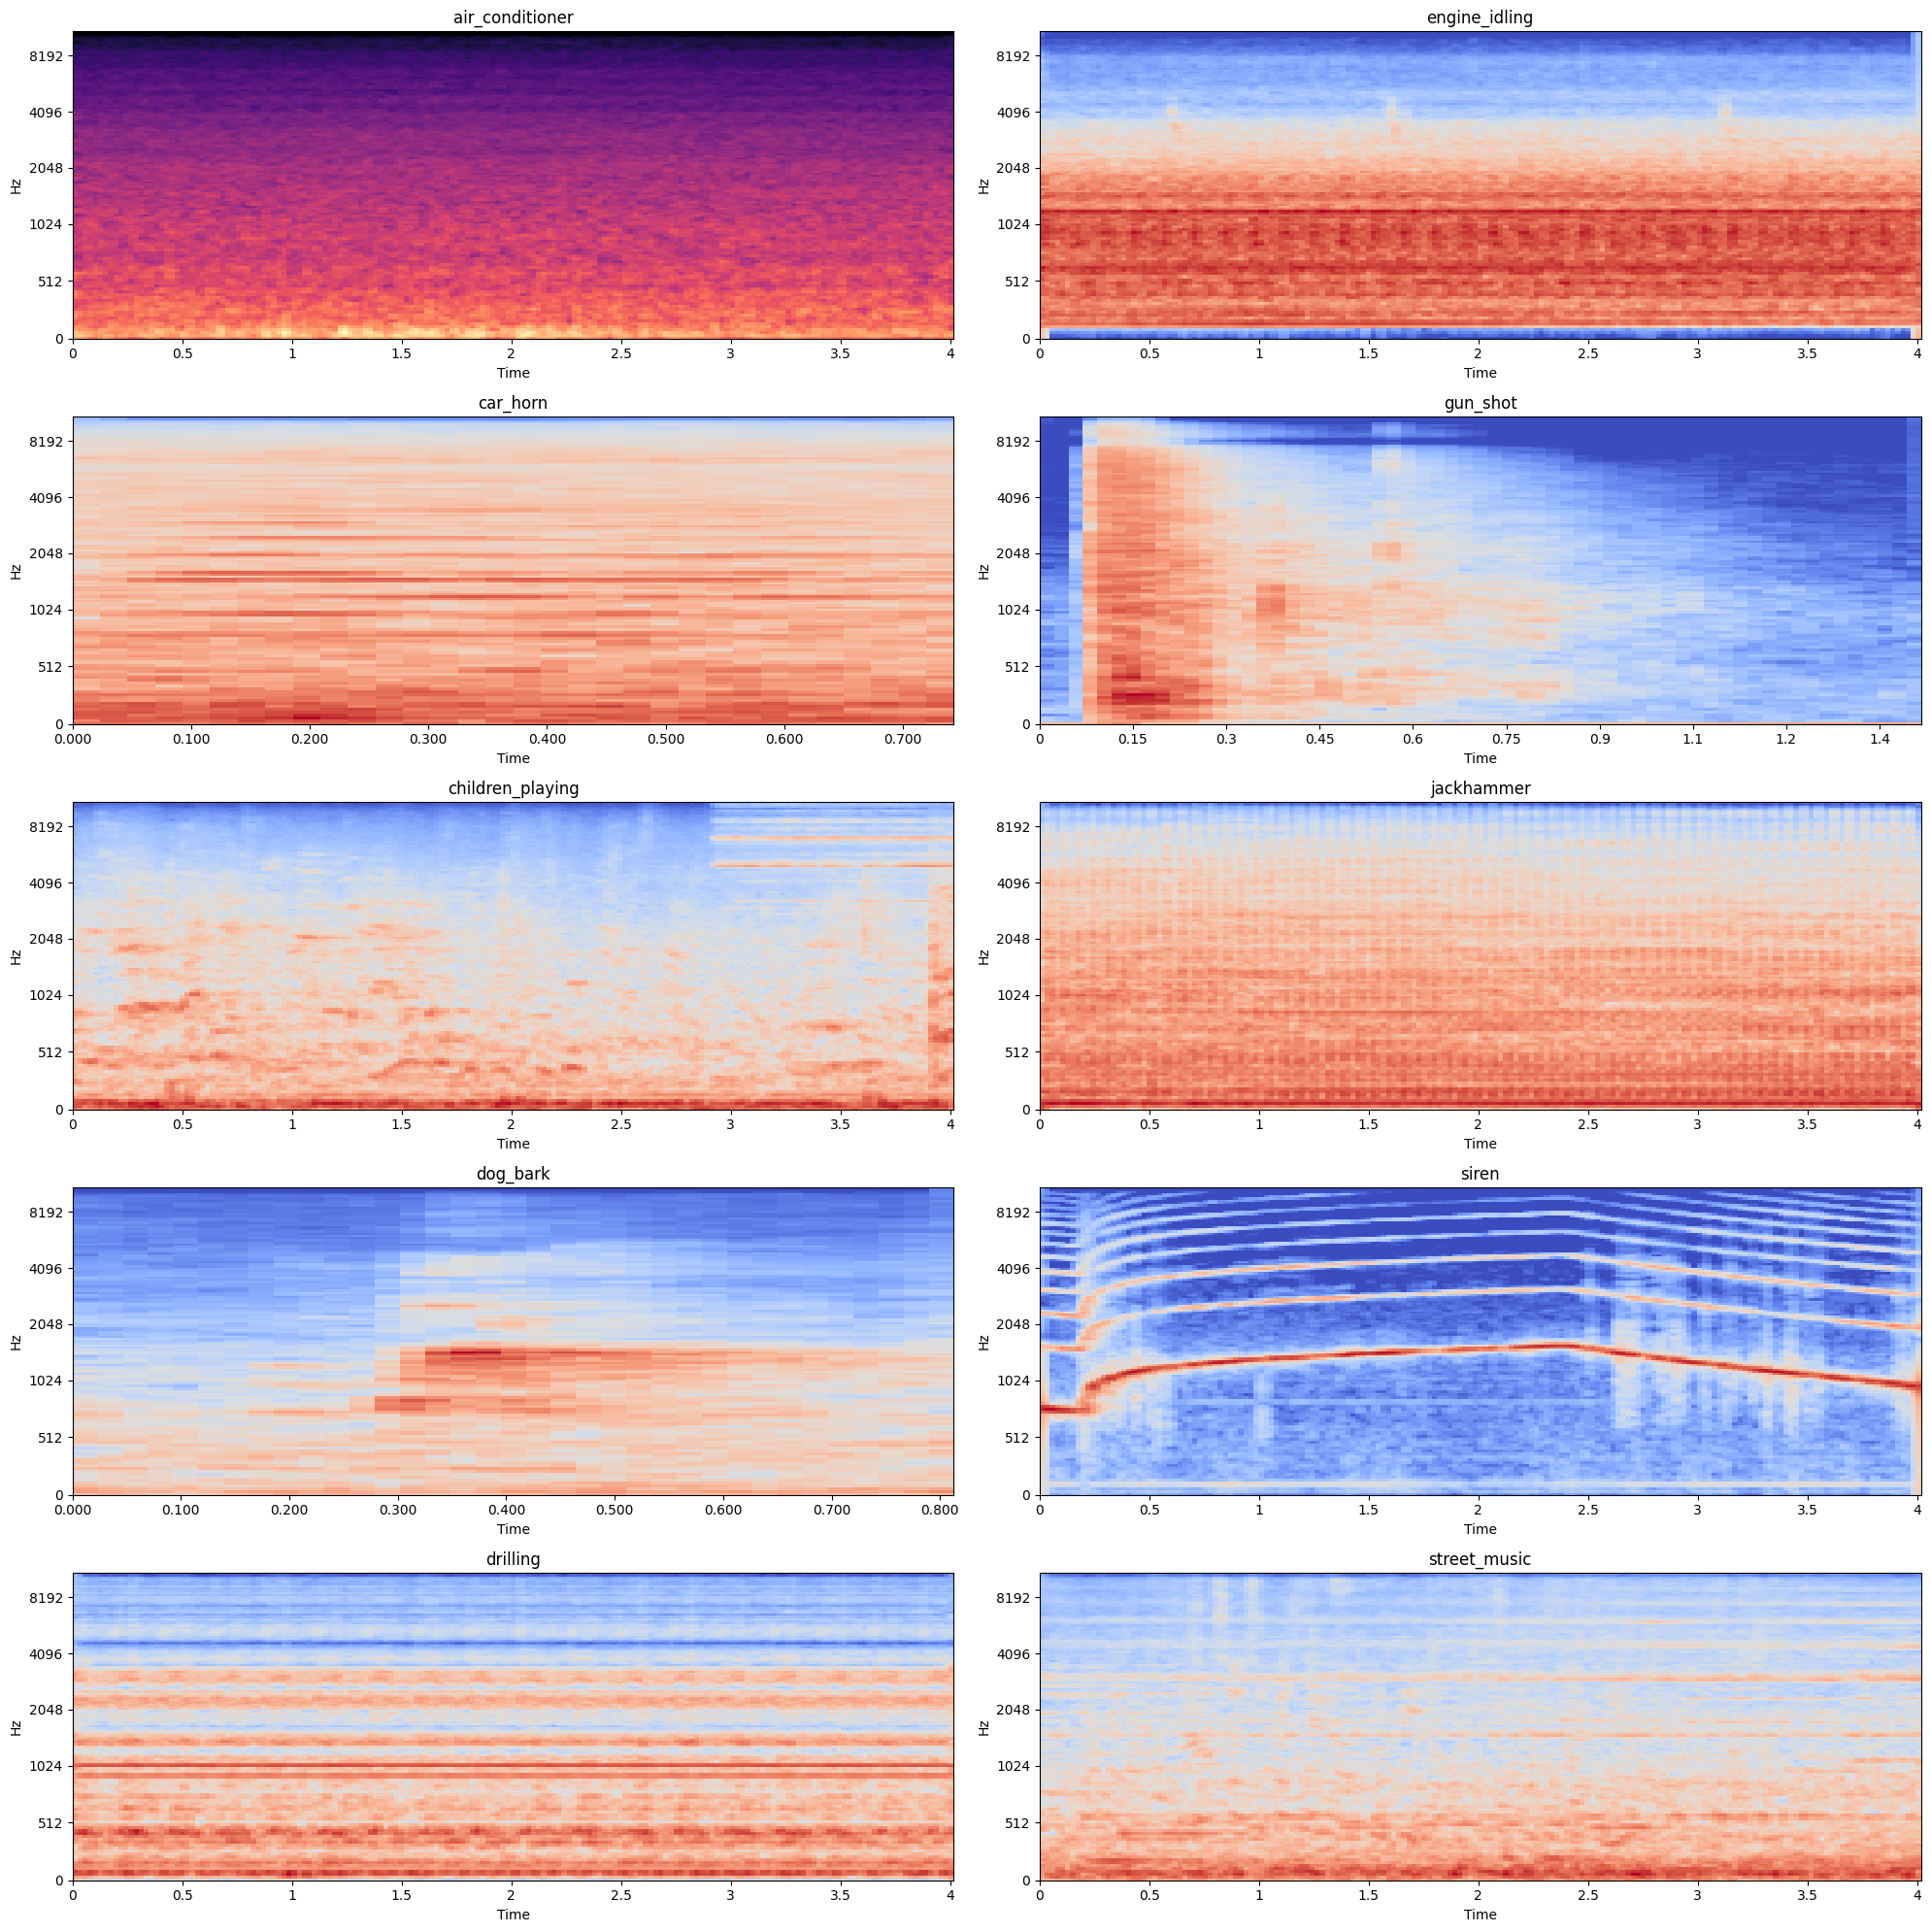

In [13]:
# Mel-Spectograms
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_sample[index])
        mel_spec = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
        log_mel_spec = librosa.power_to_db(mel_spec)
        librosa.display.specshow(log_mel_spec,
                             sr=sample_rate,
                             x_axis="time", 
                             y_axis='mel',
                             ax=axs[row][col])
        axs[row][col].set_title(f'{label[index]}')
        index += 1
fig.tight_layout()

In [14]:
index = 0 # change from 0 to 9 to listen to a different recording
print(f'Listen to {label[index]} sample')
IPython.display.Audio(audio_sample[index])

Listen to air_conditioner sample
